##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

In [2]:
!pip uninstall grpcio-status 1.71.0
!pip uninstall ydf
!pip uninstall thinc

Found existing installation: grpcio-status 1.71.0
Uninstalling grpcio-status-1.71.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/grpc_status/*
    /usr/local/lib/python3.11/dist-packages/grpcio_status-1.71.0.dist-info/*
Proceed (Y/n)? y
  Successfully uninstalled grpcio-status-1.71.0
Found existing installation: ydf 0.12.0
Uninstalling ydf-0.12.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/ydf-0.12.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/ydf/*
    /usr/local/lib/python3.11/dist-packages/yggdrasil_decision_forests/*
Proceed (Y/n)? y
  Successfully uninstalled ydf-0.12.0
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/thinc-8.3.6.dist-info/*
    /usr/local/lib/python3.11/dist-packages/thinc/*
Proceed (Y/n)? y
  Successfully uninstalled thinc-8.3.6


## Preparation

Let's start with installing MediaPipe.

In [21]:
!pip install numpy==1.26.4

In [22]:
!pip install -q mediapipe

Then download the off-the-shelf model bundle(s). Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker#models) for more information about these model bundles.

In [4]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

## Visualization utilities

In [23]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

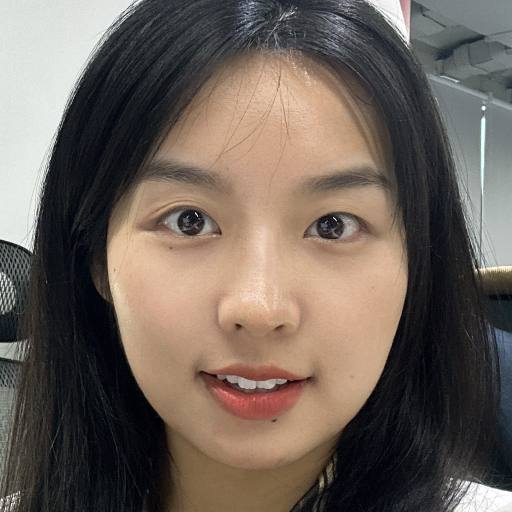

In [24]:
!wget -q -O image.png https://storage.googleapis.com/mediapipe-assets/business-person.png

import cv2
from google.colab.patches import cv2_imshow

# img = cv2.imread("image.png")
img = cv2.imread('ting_33.png_face_features.png')
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

Here are the steps to run face landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker/python) to learn more about configuration options that this task supports.


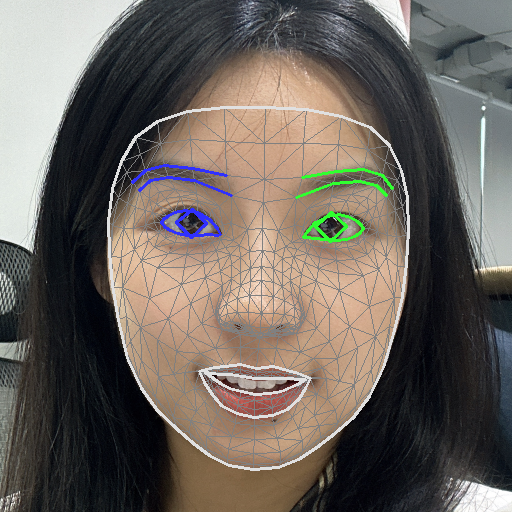

In [26]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("ting_33.png_face_features.png")

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

We will also visualize the face blendshapes categories using a bar graph.

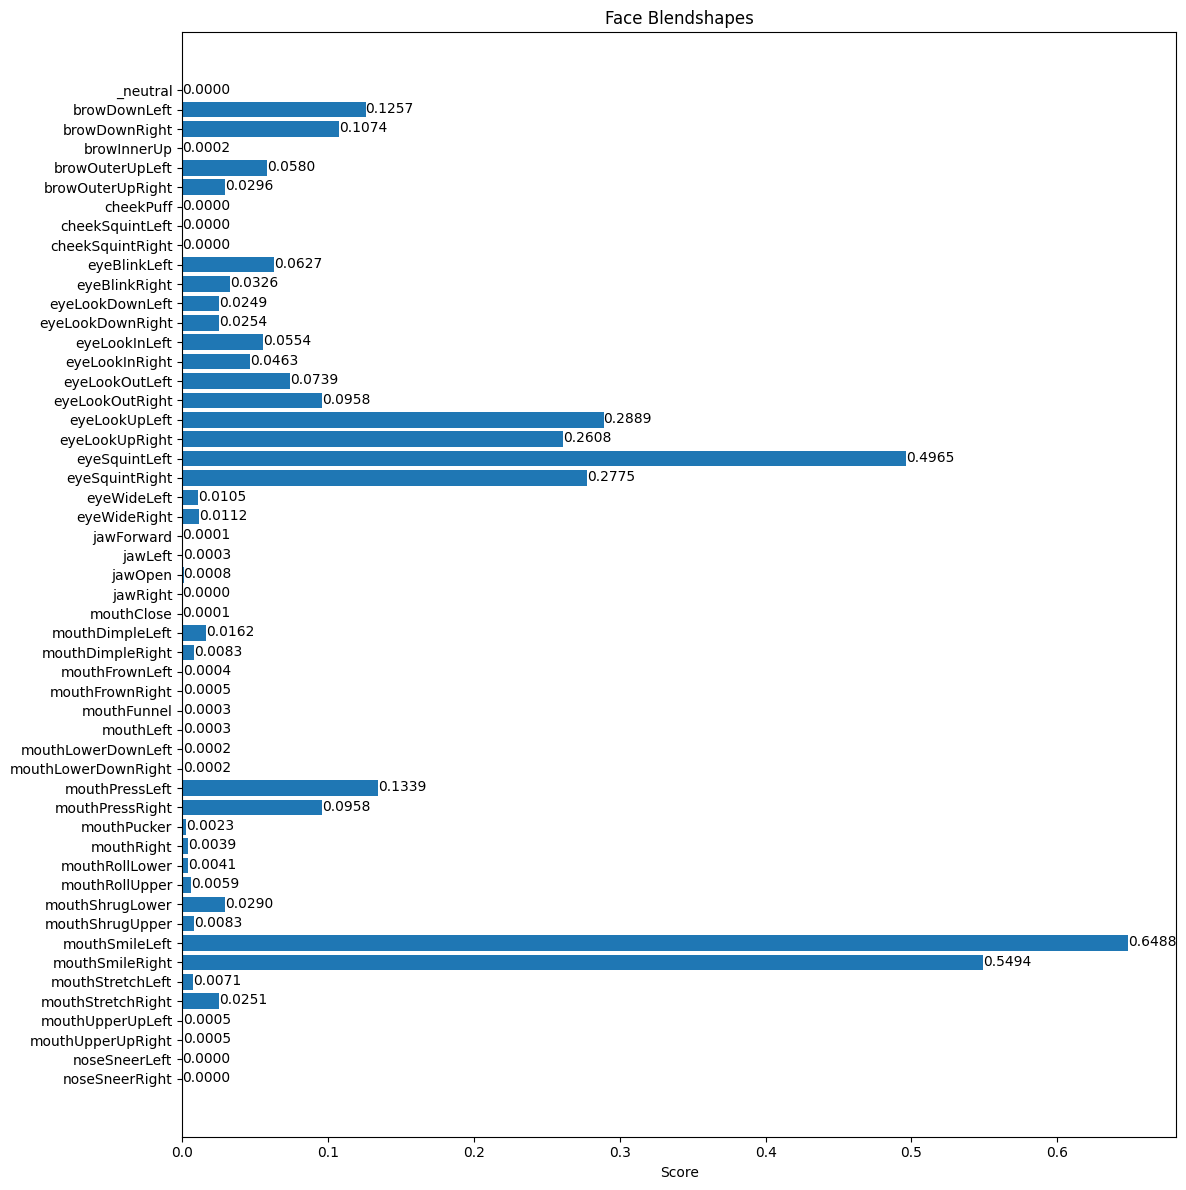

In [15]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

And print the transformation matrix.

In [16]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.92209911e-01, -6.04962148e-02,  1.08903199e-01,
         1.18749952e+00],
       [ 9.10462737e-02,  9.48806942e-01, -3.02450448e-01,
         2.23723984e+01],
       [-8.50309655e-02,  3.10009331e-01,  9.46923494e-01,
        -6.80146637e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]


In [17]:
print(detection_result.face_blendshapes[0])

[Category(index=0, score=2.72534475698194e-06, display_name='', category_name='_neutral'), Category(index=1, score=0.1256560981273651, display_name='', category_name='browDownLeft'), Category(index=2, score=0.10741740465164185, display_name='', category_name='browDownRight'), Category(index=3, score=0.00015090849774423987, display_name='', category_name='browInnerUp'), Category(index=4, score=0.05803155526518822, display_name='', category_name='browOuterUpLeft'), Category(index=5, score=0.029591195285320282, display_name='', category_name='browOuterUpRight'), Category(index=6, score=3.7630270526278764e-05, display_name='', category_name='cheekPuff'), Category(index=7, score=2.055003989198667e-07, display_name='', category_name='cheekSquintLeft'), Category(index=8, score=2.6737100711216044e-07, display_name='', category_name='cheekSquintRight'), Category(index=9, score=0.06272852420806885, display_name='', category_name='eyeBlinkLeft'), Category(index=10, score=0.032637178897857666, dis

In [18]:
print(type(detection_result.face_blendshapes[0]))

<class 'list'>


In [20]:
print(dir(detection_result))

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'face_blendshapes', 'face_landmarks', 'facial_transformation_matrixes']


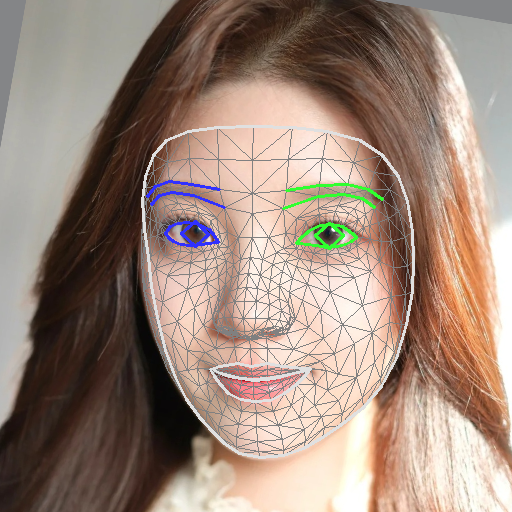

In [28]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image2 = mp.Image.create_from_file("heranvv_36.jpg_face_features.png")

# STEP 4: Detect face landmarks from the input image.
detection_result2 = detector.detect(image2)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image2 = draw_landmarks_on_image(image2.numpy_view(), detection_result2)
cv2_imshow(cv2.cvtColor(annotated_image2, cv2.COLOR_RGB2BGR))

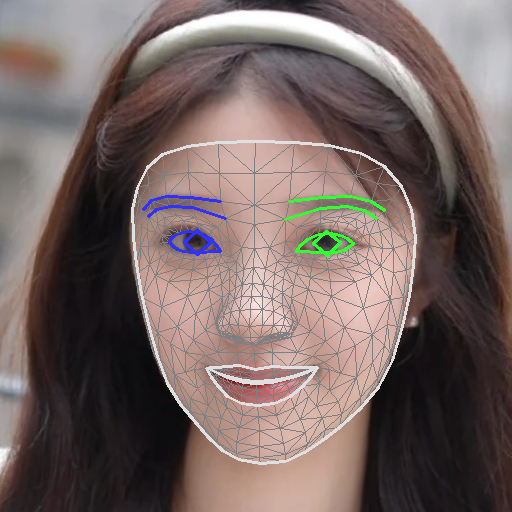

In [59]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image2 = mp.Image.create_from_file("heranvv_38.jpg_face_features.png")

# STEP 4: Detect face landmarks from the input image.
detection_result2 = detector.detect(image2)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image2 = draw_landmarks_on_image(image2.numpy_view(), detection_result2)
cv2_imshow(cv2.cvtColor(annotated_image2, cv2.COLOR_RGB2BGR))

[[Category(index=0, score=1.1998873787888442e-06, display_name='', category_name='_neutral'), Category(index=1, score=0.0022208744194358587, display_name='', category_name='browDownLeft'), Category(index=2, score=0.0019846567884087563, display_name='', category_name='browDownRight'), Category(index=3, score=0.4548131823539734, display_name='', category_name='browInnerUp'), Category(index=4, score=0.1762797236442566, display_name='', category_name='browOuterUpLeft'), Category(index=5, score=0.1500687152147293, display_name='', category_name='browOuterUpRight'), Category(index=6, score=2.132301960955374e-05, display_name='', category_name='cheekPuff'), Category(index=7, score=6.786410722270375e-07, display_name='', category_name='cheekSquintLeft'), Category(index=8, score=1.9878538637385645e-07, display_name='', category_name='cheekSquintRight'), Category(index=9, score=0.04845619574189186, display_name='', category_name='eyeBlinkLeft'), Category(index=10, score=0.018264520913362503, dis

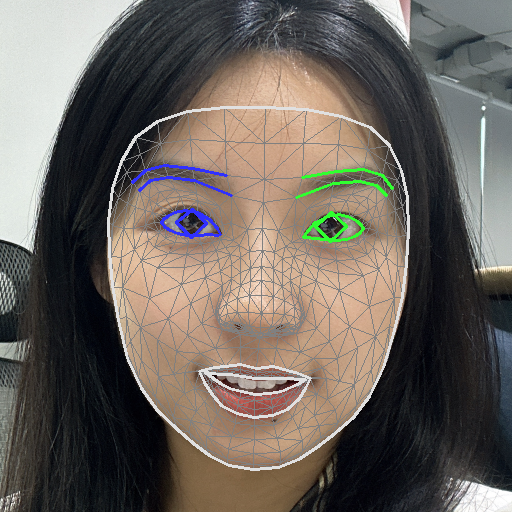

In [62]:
# detection_result.face_blendshapes = detection_result2.face_blendshapes
# detection_result.facial_transformation_matrixes = detection_result2.facial_transformation_matrixes
# STEP 3: Load the input image.
image = mp.Image.create_from_file("ting_33.png_face_features.png")
detection_result = detector.detect(image)

print(detection_result2.face_blendshapes)
print(detection_result.face_blendshapes)
detection_result.face_blendshapes = detection_result2.face_blendshapes
# detection_result.facial_transformation_matrixes = detection_result2.facial_transformation_matrixes
# detection_result.face_landmarks = detection_result2.face_landmarks

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))